In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import norm
import random
import statistics as stat
import matplotlib.pyplot as plt

In [2]:
# Price of Call Option function
def get_call(T, r, d, S0,K, sigma):
    if K==0 or T==0 or sigma ==0:
        print('Not a valid input')
    elif d == 0:
        d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)
        call = S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        return call
    elif d < 0:
        print('Not a valid dividend input')
    else:
        d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
        d2 = d1-sigma*np.sqrt(T)
        print(d1)
        call = np.exp(-d*T)*S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
        return(call)

In [3]:
# BS Delta of a call option
def get_delta_call(T,r,d,S0,K,sigma):
    d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    delta= norm.cdf(d1)
    return delta

In [4]:
# Gamma of a call option
def get_gamma_call(T,r,d,S0,K,sigma):
    d1 = (np.log(S0/K)+(r+0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1-sigma*np.sqrt(T)
    gamma= (np.exp(-d*T))/(S0*sigma*np.sqrt(T))*norm.pdf(d1)
    return gamma

In [5]:
def get_geo_path(T,r,d,sigma, S0,steps):
    dt= T/steps
    t = np.linspace(0,T,steps)
    Bt = [0]+ np.random.standard_normal(size=steps)
    Bt = np.cumsum(Bt)*np.sqrt(dt)
    path = S0*np.exp(((r-d)-0.5*sigma**2)*t+sigma*Bt)
#     plt.plot(t,path)
    return path


In [6]:
#Delta-Gamma initial hedge set up (short ATM:(-1), long OTM: X, long underlying: y)
S0=100
delta_perc=[]
gamma_perc=[]
pos_delta=[]
pos_gamma=[]
quantity=[-1]
#sell 1 unit of ATM Call
delta_1 = get_delta_call(T=1,r=0,d=0,S0=100,K=100,sigma=0.1)
gamma_1=get_gamma_call(T=1,r=0,d=0,S0=100,K=100,sigma=0.1)

delta_perc.append(delta_1)
gamma_perc.append(gamma_1)

pos_delta.append(quantity[0]*delta_1)
pos_gamma.append(quantity[0]*gamma_1)

#buy OTM calls to neutralise gamma:
delta_otm = get_delta_call(T=1,r=0,d=0,S0=100,K=130,sigma=0.1)
gamma_otm=get_gamma_call(T=1,r=0,d=0,S0=100,K=130,sigma=0.1)

delta_perc.append(delta_otm)
gamma_perc.append(gamma_otm)

pos_gamma.append(-1*quantity[0]*gamma_1)
quantity.append(pos_gamma[1]/gamma_otm)
pos_delta.append(quantity[1]*delta_perc[1])

#buy underlying to neutralise delta
pos_delta.append(pos_delta[0]+pos_delta[1])
delta_perc.append(1)
gamma_perc.append(0)
quantity.append((pos_delta[0]+pos_delta[1])*-1)

pos_gamma.append(0)


import pandas as pd

data = {
    "quantity": quantity,
    "delta%":delta_perc,
    "gamma%":gamma_perc,
    "position delta":pos_delta,
    "position gamma":pos_gamma
}
df=pd.DataFrame(data)
df.index=['short ATM call','hedge gamma w/ OTM call','hedge delta w/ underlying']


#initial premium recieved:
C0=get_call(T=1, r=0, d=0, S0=100,K=100, sigma=0.1)
#cash after initial gamma hedging
c=C0-(quantity[1]*get_call(T=1,r=0,d=0,S0=100,K=130,sigma=0.1))
#cash after initial delta hedge
c=c-quantity[2]*S0
cash=[c]

#portfolio value cash+stock+OTM option (initial ATM option premium)
portfolio=C0
pnl=portfolio-C0
print('initial pnl',pnl,'initial cash', cash)
print('Initial set up after hedge: short 1 ATM call, long 27.4 units of OTM call, long 0.382 of underlying')
df





initial pnl 0.0 initial cash [-34.64251935926486]
Initial set up after hedge: short 1 ATM call, long 27.4 units of OTM call, long 0.382 of underlying


,quantity,delta%,gamma%,position delta,position gamma
short ATM call,-1.000000,0.519939,0.039844,-0.519939,-0.039844
hedge gamma w/ OTM call,27.400691,0.005032,0.001454,0.137872,0.039844
hedge delta w/ underlying,0.382067,1.000000,0.000000,-0.382067,0.000000


In [7]:
#Delta_Gamma hedging multi-period
tau =[1.00,0.92,0.83,0.75,0.67,0.58,0.50,0.42,0.33,0.25,0.17,0.08,0.000001]

periods=len(tau)-1

totg=[]
#generate stock process
S=get_geo_path(T=1,r=0,d=0,sigma=0.1, S0=100,steps=12)
S=np.insert(S,0,100.00)


#initialise starting variables and define lists to store values in
T=1
r=0
d=0
sigma=0.1

#positions after initial Delta-Gamma hedge
delta_perc=[]
gamma_perc=[]
pos_delta=[]
pos_gamma=[]
quantity=[-1]
final_positions={}
#sell 1 unit of ATM Call
delta_1 = get_delta_call(T=tau[0],r=0,d=0,S0=S[0],K=100,sigma=0.1)
gamma_1=get_gamma_call(T=tau[0],r=0,d=0,S0=S[0],K=100,sigma=0.1)

delta_perc.append(delta_1)
gamma_perc.append(gamma_1)

pos_delta.append(quantity[0]*delta_1)
pos_gamma.append(quantity[0]*gamma_1)

#buy OTM calls to neutralise gamma:
delta_otm = get_delta_call(T=tau[0],r=0,d=0,S0=S[0],K=130,sigma=0.1)
gamma_otm=get_gamma_call(T=tau[0],r=0,d=0,S0=S[0],K=130,sigma=0.1)

delta_perc.append(delta_otm)
gamma_perc.append(gamma_otm)

pos_gamma.append(-1*quantity[0]*gamma_1)
quantity.append(pos_gamma[1]/gamma_otm)
pos_delta.append(quantity[1]*delta_perc[1])

#buy underlying to neutralise delta
pos_delta.append(pos_delta[0]+pos_delta[1])
delta_perc.append(1)
gamma_perc.append(0)
quantity.append((pos_delta[0]+pos_delta[1])*-1)

pos_gamma.append(0)

final_positions['short ATM']=quantity[0]
final_positions['long OTM']=quantity[1]
final_positions['long underlying']=quantity[2]

#initial premium recieved:
C0=get_call(T=1, r=0, d=0, S0=100,K=100, sigma=0.1)
#cash after initial gamma hedging
c=C0-(quantity[1]*get_call(T=1,r=0,d=0,S0=100,K=130,sigma=0.1))
#cash after initial delta hedge
c=c-quantity[2]*S0
cash=[c]

#portfolio value cash+stock+OTM option (initial ATM option premium)
portfolio=[C0]
pnl=[portfolio[0]-C0]

print('initial hedge positions', final_positions)

for t in range(1,len(tau)):

    #delta and gamma of ATM short call
    delta_perc=[]
    gamma_perc=[]
    pos_delta=[]
    pos_gamma=[]
    quantity=[-1]
    
    delta_perc.append(get_delta_call(T=tau[t],r=0,d=0,S0=S[t],K=100,sigma=0.1))
    gamma_perc.append(get_gamma_call(T=tau[t],r=0,d=0,S0=S[t],K=100,sigma=0.1))
    
    qatm= final_positions['short ATM']

    pos_delta.append(qatm*delta_perc[0])
    pos_gamma.append(qatm*gamma_perc[0])
    
    #delta and gamma of OTM long calls
    delta_perc.append(get_delta_call(T=tau[t],r=0,d=0,S0=S[t],K=130,sigma=0.1))
    gamma_perc.append(get_gamma_call(T=tau[t],r=0,d=0,S0=S[t],K=130,sigma=0.1))
    
    qotm=final_positions['long OTM']
    
    pos_gamma.append(qotm*gamma_perc[1])
    
    if gamma_perc[1]==0:
        gamma_perc[1]=0.0000000001
   
    
    #quantity of OTM to make gamma neutral
    total_otm=-1*qatm*gamma_perc[0]/gamma_perc[1]

    #how many otm options to buy or sell based on current otm positions
    
    if total_otm < qotm: # total portfolio gamma + -> need to sell some otm
        buy_sell_g='sell'
        buy_sell_otm= qotm-total_otm
    elif total_otm>qotm: #portfolio gamma - -> need to buy
        buy_sell_g='buy'
        buy_sell_otm = (total_otm-qotm)*-1
    else:
        buy_sell_g='do nothing'
        buy_sell_otm=0

    
    
    #delta hedge with underlying
    pos_delta.append(total_otm*delta_perc[1])
    total_underlying=-1*sum(pos_delta) #delta short ATM + long OTM 

    
    #quantity of buy/sell underlying to hedge delta
    if total_underlying> final_positions['long underlying']:
        buy_sell_d= 'buy'
        buy_sell_underlying=(total_underlying-final_positions['long underlying'])*-1
    elif total_underlying<final_positions['long underlying']:
        buy_sell_d='sell'
        buy_sell_underlying=final_positions['long underlying']-total_underlying
    else:
        buy_sell_d='do nothing'
        buy_sell_underlying=0
    
    #adjustments to avoid infinity/ divide by 0
    if total_otm>2.0e20:
        total_otm=1000000000
    if total_underlying < 1.0e-20:
        total_underlying=0
    
    final_positions.update({'long OTM':total_otm,'long underlying':total_underlying})


    

    otm_call=get_call(T=tau[t], r=0, d=0, S0=S[t],K=130, sigma=0.1)
    
    #cash flow = previous cash + buy/sell OTM call + buy/sell underlying
    cash_flow=cash[t-1]+(buy_sell_otm*otm_call)+(buy_sell_underlying*S[t])
    cash.append(cash_flow)


    #portfolio value cash+stock+OTM option (initial ATM option premium)
    portfolio.append(cash[t]+ final_positions['long OTM']*otm_call+final_positions['long underlying']*S[t])
    
    atm_call = get_call(T=tau[t],r=0,d=0, S0=S[t],K=100,sigma=0.1)
    pnl.append(portfolio[t]-atm_call)
    
    print('positions after re-hedging', final_positions)


final_pnl=pnl[-1]-max(S[-1]-100,0)

print('final_pnl', final_pnl)


    
import pandas as pd

data = {
    "Stock": S,
    "Cash": cash,
    "pnl":pnl,
}
df=pd.DataFrame(data)
df

 




initial hedge positions {'short ATM': -1, 'long OTM': 27.400690977819096, 'long underlying': 0.3820665377158621}
positions after re-hedging {'short ATM': -1, 'long OTM': 113.83142893648204, 'long underlying': 0.24753864370244152}
positions after re-hedging {'short ATM': -1, 'long OTM': 118.53309449130126, 'long underlying': 0.29817532876548064}
positions after re-hedging {'short ATM': -1, 'long OTM': 140.950028240532, 'long underlying': 0.3369892397132237}
positions after re-hedging {'short ATM': -1, 'long OTM': 79.2069913609906, 'long underlying': 0.47507583198764813}
positions after re-hedging {'short ATM': -1, 'long OTM': 378.1617626202076, 'long underlying': 0.3920283011290495}
positions after re-hedging {'short ATM': -1, 'long OTM': 110.21313005206177, 'long underlying': 0.6228790243035539}
positions after re-hedging {'short ATM': -1, 'long OTM': 331.00689409347103, 'long underlying': 0.6324612335045229}
positions after re-hedging {'short ATM': -1, 'long OTM': 373.85057633803905, 

,Stock,Cash,pnl
0,100.000000,-34.642519,0.000000
1,96.132347,-21.918871,0.022886
2,97.625348,-26.873288,-0.013595
3,98.607385,-30.742619,-0.027303
4,101.631430,-44.560591,-0.171895
5,99.707621,-36.441895,-0.038179
6,103.983907,-59.970268,-0.301342
7,103.686307,-61.064940,-0.211703
8,105.656414,-76.029799,-0.346533
9,103.495359,-68.072896,-0.161711


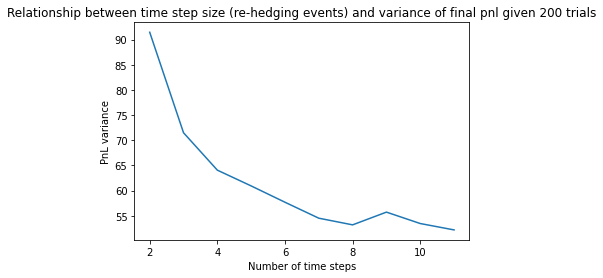

'Increasing time steps leads to less variance in pnl'

In [25]:
#change in variance of pnl with respect to re-hedging events (periods) - Monte Carlo approach
final_pnl=[]
variance=[]
steps=12
trials=252
for s in range (2,steps):
    for mc in range(0,trials):
        time=np.linspace(0.001,1,s)
        tau=time[::-1]


        periods=len(tau)-1

        #generate stock process
        S=get_geo_path(T=1,r=0,d=0,sigma=0.1, S0=100,steps=s-1)
        S=np.insert(S,0,100.00)
#         print('t',tau)
#         print('S',S)


        #initialise starting variables and define lists to store values in
        T=1
        r=0
        d=0
        sigma=0.1

        #positions after initial Delta-Gamma hedge
        delta_perc=[]
        gamma_perc=[]
        pos_delta=[]
        pos_gamma=[]
        quantity=[-1]
        final_positions={}
        #sell 1 unit of ATM Call
        delta_1 = get_delta_call(T=tau[0],r=0,d=0,S0=S[0],K=100,sigma=0.1)
        gamma_1=get_gamma_call(T=tau[0],r=0,d=0,S0=S[0],K=100,sigma=0.1)

        delta_perc.append(delta_1)
        gamma_perc.append(gamma_1)

        pos_delta.append(quantity[0]*delta_1)
        pos_gamma.append(quantity[0]*gamma_1)

        #buy OTM calls to neutralise gamma:
        delta_otm = get_delta_call(T=tau[0],r=0,d=0,S0=S[0],K=130,sigma=0.1)
        gamma_otm=get_gamma_call(T=tau[0],r=0,d=0,S0=S[0],K=130,sigma=0.1)

        delta_perc.append(delta_otm)
        gamma_perc.append(gamma_otm)

        pos_gamma.append(-1*quantity[0]*gamma_1)
        quantity.append(pos_gamma[1]/gamma_otm)
        pos_delta.append(quantity[1]*delta_perc[1])

        #buy underlying to neutralise delta
        pos_delta.append(pos_delta[0]+pos_delta[1])
        delta_perc.append(1)
        gamma_perc.append(0)
        quantity.append((pos_delta[0]+pos_delta[1])*-1)

        pos_gamma.append(0)

        final_positions['short ATM']=quantity[0]
        final_positions['long OTM']=quantity[1]
        final_positions['long underlying']=quantity[2]

        #initial premium recieved:
        C0=get_call(T=1, r=0, d=0, S0=100,K=100, sigma=0.1)
        #cash after initial gamma hedging
        c=C0-(quantity[1]*get_call(T=1,r=0,d=0,S0=100,K=130,sigma=0.1))
        #cash after initial delta hedge
        c=c-quantity[2]*S0
        cash=[c]

        #portfolio value cash+stock+OTM option (initial ATM option premium)
        portfolio=[C0]
        pnl=[portfolio[0]-C0]

#         print('initial hedge positions', final_positions)

        for t in range(1,len(tau)):

            #delta and gamma of ATM short call
            delta_perc=[]
            gamma_perc=[]
            pos_delta=[]
            pos_gamma=[]
            quantity=[-1]

            delta_perc.append(get_delta_call(T=tau[t],r=0,d=0,S0=S[t],K=100,sigma=0.1))
            gamma_perc.append(get_gamma_call(T=tau[t],r=0,d=0,S0=S[t],K=100,sigma=0.1))

            qatm= final_positions['short ATM']

            pos_delta.append(qatm*delta_perc[0])
            pos_gamma.append(qatm*gamma_perc[0])

            #delta and gamma of OTM long calls
            delta_perc.append(get_delta_call(T=tau[t],r=0,d=0,S0=S[t],K=130,sigma=0.1))
            gamma_perc.append(get_gamma_call(T=tau[t],r=0,d=0,S0=S[t],K=130,sigma=0.1))

            qotm=final_positions['long OTM']

            pos_gamma.append(qotm*gamma_perc[1])

            if gamma_perc[1]==0:
                gamma_perc[1]=0.0000000001


            #quantity of OTM to make gamma neutral
            total_otm=-1*qatm*gamma_perc[0]/gamma_perc[1]

            #how many otm options to buy or sell based on current otm positions

            if total_otm < qotm: # total portfolio gamma + -> need to sell some otm
                buy_sell_g='sell'
                buy_sell_otm= qotm-total_otm
            elif total_otm>qotm: #portfolio gamma - -> need to buy
                buy_sell_g='buy'
                buy_sell_otm = (total_otm-qotm)*-1
            else:
                buy_sell_g='do nothing'
                buy_sell_otm=0



            #delta hedge with underlying
            pos_delta.append(total_otm*delta_perc[1])
            total_underlying=-1*sum(pos_delta) #delta short ATM + long OTM 


            #quantity of buy/sell underlying to hedge delta
            if total_underlying> final_positions['long underlying']:
                buy_sell_d= 'buy'
                buy_sell_underlying=(total_underlying-final_positions['long underlying'])*-1
            elif total_underlying<final_positions['long underlying']:
                buy_sell_d='sell'
                buy_sell_underlying=final_positions['long underlying']-total_underlying
            else:
                buy_sell_d='do nothing'
                buy_sell_underlying=0

            #adjustments to avoid infinity/ divide by 0
            if total_otm>2.0e20:
                total_otm=1000000000
            if total_underlying < 1.0e-20:
                total_underlying=0

            final_positions.update({'long OTM':total_otm,'long underlying':total_underlying})




            otm_call=get_call(T=tau[t], r=0, d=0, S0=S[t],K=130, sigma=0.1)

            #cash flow = previous cash + buy/sell OTM call + buy/sell underlying
            cash_flow=cash[t-1]+(buy_sell_otm*otm_call)+(buy_sell_underlying*S[t])
            cash.append(cash_flow)


            #portfolio value cash+stock+OTM option (initial ATM option premium)
            portfolio.append(cash[t]+ final_positions['long OTM']*otm_call+final_positions['long underlying']*S[t])

            atm_call = get_call(T=tau[t],r=0,d=0, S0=S[t],K=100,sigma=0.1)
            pnl.append(portfolio[t]-atm_call)

#             print('positions after re-hedging', final_positions)


        final_pnl.append(pnl[-1]-max(S[-1]-100,0))
    
    variance.append(np.var(final_pnl))


x=[i for i in range(2,steps)]


plt.plot(x,variance)
plt.title('Relationship between time step size (re-hedging events) and variance of final pnl given 200 trials')
plt.xlabel('Number of time steps')
plt.ylabel('PnL variance')
plt.show()

'Increasing time steps leads to less variance in pnl'
    